In [1]:
import os
import ee
import datetime
import tqdm
import json

import pandas as pd
import geopandas as gp
import numpy as np
import rsfuncs as rs

import scipy.interpolate as interp
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2
ee.Initialize()

In [232]:
# Helper functions 

def dict2arr(data_dict, var_name):
    '''converts ee dictionary output from .getInfo() to a numpy array. Wraps array_from_df'''
    
    data = data_dict[var_name]
    lats = data_dict['latitude']
    lons = data_dict['longitude']

    df = pd.DataFrame([data,lats,lons]).T
    df.columns = [var_name, "latitude", 'longitude']
    arr = rs.array_from_df(df, var_name)
    
    return arr

def map_cdl2fmp(dictionary,array):
    '''maps values on cdl image to the fmp'''
    
    mapping = dictionary.copy()
    
    vec1 = []
    vec2 = []

    for k,v in mapping.items():
        for i in v:
            if i == "":
                continue
            else:
                vec1.append(int(i))
                vec2.append(int(k))
                
    out_im = np.zeros_like(array)
    for k,v in dict(zip(vec1,vec2)).items():
        out_im[array==k] =v
    
    return out_im


def map_fmp2kc(dictionary,array):
    '''maps values on fmp image to kc'''

    mapping = dictionary.copy()
    
    vec1 = []
    vec2 = []

    for k,v in mapping.items():
        vec1.append(k)
        vec2.append(v)
                
    out_im = np.zeros_like(array)
    for k,v in dict(zip(vec1,vec2)).items():
        out_im[array==k] =v
    
    return out_im


def get_monthly_et(dataset, start, end, aoi):
    '''
    Get gridded monthly ET sums from MODIS 
    '''

    ImageCollection = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]
    resolution = dataset[3]

    dt_idx = pd.date_range(start,end, freq='MS')
    ims = []
    seq = ee.List.sequence(0, len(dt_idx)-1)
    num_steps = seq.getInfo()
    
    for i in num_steps[:]:

        t1 = ee.Date(start).advance(i, 'month')
        t2 = t1.advance(1, 'month');

        im = ee.Image(ImageCollection.select(var).filterDate(t1, t2).sum().set('system:time_start', t1.millis()))
        modis_dat = im.pixelLonLat().addBands(im).multiply(scaling_factor).reduceRegion(reducer=ee.Reducer.toList(),
                                                               geometry=aoi,
                                                               scale=1000, crs ='EPSG:4326')

        modis_dict = modis_dat.getInfo()
        modis_im = dict2arr(modis_dict, var)
        ims.append(modis_im)

    return ims

def calc_monthly_sum(dataset, startdate, enddate, area):
    '''
    Calculates monthly sums (pd.Dataframe) for EE data given startdate, enddate, and area
    Datasets are stored in `data` dict below.
    Note the "scaling_factor" parameter, 
    which is provided by EE for each dataset, and further scaled by temporal resolution to achieve monthly resolution
    This is explicitly written in the `data` dict 
    
    EE will throw a cryptic error if the daterange you input is not valid for the product of interest, or if the AOI is e.g. in middle of ocean
    '''

    ImageCollection = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]
    resolution = dataset[3]
    
    dt_idx = pd.date_range(startdate,enddate, freq='MS')
    sums = []
    seq = ee.List.sequence(0, len(dt_idx)-1)
    num_steps = seq.getInfo()

    for i in num_steps:

        start = ee.Date(startdate).advance(i, 'month')
        end = start.advance(1, 'month');

        im = ee.Image(ImageCollection.select(var).filterDate(start, end).sum().set('system:time_start', start.millis()))
        scale = im.projection().nominalScale()
        scaled_im = im.multiply(scaling_factor).multiply(ee.Image.pixelArea()).multiply(1e-12) # mm --> km^3
        
        sumdict  = scaled_im.reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = area,
            scale = resolution,
            bestEffort= True)

        total = sumdict.getInfo()[var]
        sums.append(total)
        
    sumdf = pd.DataFrame(np.array(sums), dt_idx)
    sumdf.columns = [var]
    df = sumdf.astype(float)
        
    return df

def resample_1km_30m(im_1km,im_30m):
    '''
    Interpolates 1 km modis data on to 30m landsat grid
    '''
    
    W, H = im_1km.shape[:2]
    new_W, new_H = im_30m.shape[:2]
    xrange = lambda x: np.linspace(0, 1, x)

    f = interp.interp2d(xrange(H), xrange(W), im_1km, kind="linear")
    new_arr = f(xrange(new_H), xrange(new_W))
    
    return new_arr


def interp_modis_nans(modis_image):
    '''
    interpolates nans in modis imagery. Doesn't work if a whole row/col at edge of image is all nans 
    '''

    W, H = modis_image.shape[:2]

    # Mask nans 
    array = np.ma.masked_invalid(modis_image)

    # Make the outgrid 
    xi = np.linspace(0, H, H)
    yi = np.linspace(0, W, W)
    xx, yy = np.meshgrid(xi, yi)

    # xx, yy = np.meshgrid(new_W, new_H)
    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]

    new_arr = interp.griddata((x1, y1), newarr.ravel(), (xx, yy),method='linear')
    
    return new_arr

In [111]:
# Read files, make polygons
kc = pd.read_csv('../data/fmp_kc_faunt.csv')
gdf = gp.read_file("../shape/cv.shp")
data = rs.load_data()

# Split cv into polygons
area = rs.gdf_to_ee_poly(gdf.simplify(0.01))
polys = rs.gen_polys(area, dx = 0.2, dy = 0.2)
polydict = polys.getInfo()

strstart = '2001-01-01'
strend = '2019-12-31'

startdate = datetime.datetime.strptime(strstart, "%Y-%m-%d")
enddate = datetime.datetime.strptime(strend, "%Y-%m-%d")
years = range(2001, 2020)

In [96]:
# Ensure each poly is a single geometry 

valid_polys = []

for i in tqdm(polydict['features'][:]):
    aoi = ee.Geometry.Polygon(i['geometry']['coordinates']).intersection(area)
    pols = aoi.getInfo()['coordinates']
    if len(pols) == 0:
        continue
    if len(pols) == 1:
        valid_polys.append(ee.Geometry.Polygon(pols))
    if len(pols) > 1:
        for i in pols:
#             print(i)
            valid_polys.append(ee.Geometry.Polygon(i))


In [266]:
aoi= valid_polys[147]

for y in tqdm(years[:1]):
    
    # print year and nlcd col 
    print(y)
    
    yearstart = "{}-01-01".format(str(y))
    yearend = "{}-12-31".format(str(y))

    # Select the nlcd dataset
    nlcd_col = ee.ImageCollection('USGS/NLCD')

    # find the nearest nlcd year available 
    nlcd = nlcd_col.filterDate(ee.Date(yearstart).advance(-1, 'years'), ee.Date(yearstart).advance(2, 'years')).first()
    if not nlcd_col.getInfo():
        nlcd = nlcd_col.filterDate(ee.Date(yearstart).advance(-3, 'years'), ee.Date(yearstart).advance(2, 'years')).first()

    # Compile NLCD 
    nlcd_dat = ee.Image.pixelLonLat().addBands(nlcd).reduceRegion(reducer=ee.Reducer.toList(),geometry=aoi,scale=30)
    nlcd_dict = nlcd_dat.getInfo()
    
    # get PET classes (11-water, 81-crops, 82-pasture), and make everything else AET 
    nlcd_im = dict2arr(nlcd_dict, 'landcover')
    petmask = np.isin(nlcd_im, [11,81,82], invert = False).reshape(nlcd_im.shape).astype(int)
    aetmask = np.isin(nlcd_im, [11,81,82], invert = True).reshape(nlcd_im.shape).astype(int)

    # Select the correct or most recent CDL
    if y < 2008:
        cdl = ee.Image("USDA/NASS/CDL/2008")
    else:
        cdl = ee.Image("USDA/NASS/CDL/{}".format(str(y)))
        
    # Compile CDL
    cdl_dat = ee.Image.pixelLonLat().addBands(cdl).reduceRegion(reducer=ee.Reducer.toList(),geometry=aoi,scale=30)
    cdl_dict = cdl_dat.getInfo()

    # Make the ims 
    cdl_im = dict2arr(cdl_dict, 'cropland')

    # Map values from the CDL to the FMP
    mapping = rs.cdl_2_faunt()    
    fmp_im = map_cdl2fmp(mapping, cdl_im)

    # Map values from the FMP to kc (Schmid, 2004)
    monthly_ims = []

    for i in kc.columns[2:]:
        kcvals = kc[i]
        kckeys =kc[kc.columns[0]]
        kcdict = dict(zip(kckeys, kcvals))
        kc_im = map_fmp2kc(kcdict, fmp_im)
        monthly_ims.append(kc_im)

    aet = rs.calc_monthly_sum(data['modis_aet'],  yearstart,  yearend,  aoi)
    pet = rs.calc_monthly_sum(data['modis_pet'], yearstart,  yearend, aoi)

    aetims =  get_monthly_et(data['modis_aet'],  yearstart,  yearend, aoi = aoi) 
    petims = get_monthly_et(data['modis_pet'],  yearstart,  yearend, aoi = aoi)
    
    # Apply the kc method, convert mm to km = 1e-6; m^2 to km^2 = 1e-6; 900 m^2 / cell 
    sums = []
    for aetim, petim ,kcim in zip(aetims, petims, monthly_ims):
        tpet = np.nansum(resample_1km_30m(interp_modis_nans(petim), kcim)* kcim *petmask)* 1e-12 * 900
        taet = np.nansum(resample_1km_30m(interp_modis_nans(aetim), kcim)* aetmask)*1e-12 * 900
        sums.append(np.sum([tpet, taet]))

    petsum = [np.nansum(x)*1e-9 * 900 for x in petims]
    aetsum = [np.nansum(x)*1e-9 * 900 for x in aetims]
        
    ETdf = pd.DataFrame([sums]).T.set_index(pet.index) 
    ETdf.columns = ['ETkc']

    ETdf['petsum'] = pet
    ETdf['aetsum'] = aet
    ETdf['aetimsum'] = aetsum
    ETdf['petimsum'] = petsum
    ETdf['kc_mean'] = np.array([np.mean(x) for x in monthly_ims])
    ETdf['irr_frac'] = petmask.sum()/(petmask.sum() + aetmask.sum())


2001
processing:
MODIS/006/MOD16A2/2001_01_01



processing:
MODIS/006/MOD16A2/2001_01_01


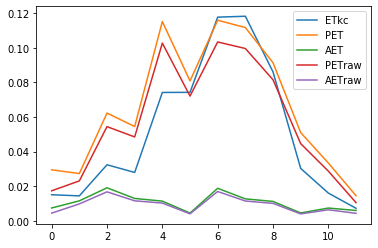

In [267]:
plt.plot(sums, label = 'ETkc')
plt.plot(petsum, label = 'PET')
plt.plot(aetsum, label = 'AET')
plt.plot(pet.values,label = 'PETraw')
plt.plot(aet.values, label = 'AETraw')
plt.legend()

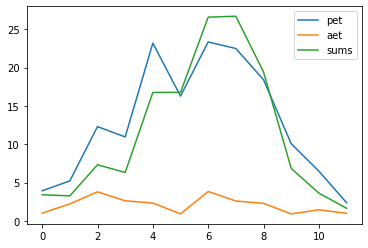

In [268]:
plt.plot(pet.values*len(valid_polys), label = 'pet')
plt.plot(aet.values*len(valid_polys),label = 'aet')
plt.plot(np.array(sums)*len(valid_polys), label = 'sums')
plt.legend()

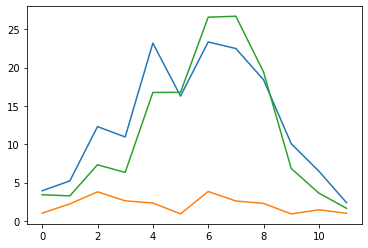

In [269]:
plt.plot(pet.values*len(valid_polys))
plt.plot(aet.values*len(valid_polys))
plt.plot(np.array(sums)*len(valid_polys))

In [270]:
ETdf

,ETkc,petsum,aetsum,aetimsum,petimsum,kc_mean,irr_frac
2001-01-01,0.015063,0.017343,0.004429,0.007418,0.029456,0.474093,0.907548
2001-02-01,0.014405,0.023058,0.009763,0.011522,0.027304,0.481636,0.907548
2001-03-01,0.032384,0.054421,0.016739,0.019078,0.062236,0.487054,0.907548
2001-04-01,0.027933,0.048441,0.011550,0.012917,0.054460,0.487883,0.907548
2001-05-01,0.074148,0.102660,0.010250,0.011376,0.115109,0.627355,0.907548
2001-06-01,0.074214,0.072061,0.004032,0.004467,0.080814,0.889707,0.907548
2001-07-01,0.117656,0.103320,0.016937,0.018779,0.115861,0.970123,0.907548
2001-08-01,0.118178,0.099536,0.011437,0.012673,0.111649,1.012950,0.907548
2001-09-01,0.086005,0.081487,0.010076,0.011197,0.091286,0.907279,0.907548
2001-10-01,0.030264,0.044576,0.003983,0.004533,0.050975,0.579182,0.907548
